<a href="https://colab.research.google.com/github/NicoBrandstetterr/location-of-the-sigma-spindles-in-EEG/blob/keim-job/Proyecto_inteligencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importamos librerias

In [211]:
from IPython.display import clear_output 
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import os
import sys
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

#from sklearn.model_selection import train_test_split
#import cv2
#import random
#from PIL import Image
#from xml.dom import minidom
#import csv

### Se cargan datos

In [212]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [213]:
!unzip "/content/drive/MyDrive/Cursos/Primavera 2022/Inteligencia/Proyecto/Data/Localización de husos sigma.zip" -d "/content/data"
clear_output() 
print('****Base de datos descomprimida****')

****Base de datos descomprimida****


### Se crean arrays con los datos y se normaliza

In [310]:
test_marks    = np.load('data/Localización de husos sigma en el EEG del sueño/test_marks.npy')
test_signals  = np.load('data/Localización de husos sigma en el EEG del sueño/test_signals.npy')
train_marks   = np.load('data/Localización de husos sigma en el EEG del sueño/train_marks.npy')[1:]
train_signals = np.load('data/Localización de husos sigma en el EEG del sueño/train_signals.npy')[1:]
val_marks     = np.load('data/Localización de husos sigma en el EEG del sueño/val_marks.npy')
val_signals   = np.load('data/Localización de husos sigma en el EEG del sueño/val_signals.npy')

In [311]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(np.concatenate((test_signals,train_signals,val_signals)))

val_signals_normalized = scaler.transform(val_signals)
test_signals_normalized = scaler.transform(test_signals)
train_signals_normalized = scaler.transform(train_signals)

### Ploteamos una serie de tiempo con la lozalización del uso

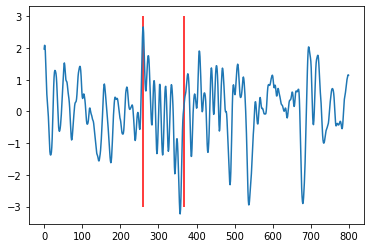

In [312]:
t = np.arange(len(test_signals_normalized[0]))
plt.plot(t,test_signals_normalized[0])
plt.vlines(test_marks[0],-3,3,colors="r")

### Se crean datasets de pytorch

In [313]:
val_marks = torch.tensor(val_marks)
test_marks = torch.tensor(test_marks)
train_marks = torch.tensor(train_marks)

val_signals = torch.tensor(val_signals_normalized)
test_signals = torch.tensor(test_signals_normalized)
train_signals = torch.tensor(train_signals_normalized)

In [314]:
train_ds = torch.utils.data.TensorDataset(train_signals, train_marks)
val_ds = torch.utils.data.TensorDataset(val_signals, val_marks)
test_ds = torch.utils.data.TensorDataset(test_signals, test_marks)

### Se define modelo

In [514]:
C=1

In [587]:
class CNN_Model(nn.Module):

    def __init__(
        self,
        dropout_p
    ):
        
        super().__init__()
        self.spatial_filtering = nn.Sequential(
            nn.Conv2d(1, C, kernel_size=(C, 1), stride=1),
        )

        self.conv_blocks = nn.Sequential(
            
            nn.Conv2d(1, 4, kernel_size=(1,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((1,2)),

            nn.Conv2d(4, 8, kernel_size=(1,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((1,2)),

            nn.Conv2d(8, 16,kernel_size=(1,3), stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((1,2)),

            nn.Conv2d(16,32,kernel_size=(1,3), stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((1,2)),

            nn.Conv2d(32,64,kernel_size=(1,3), stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((1,2)),

        )

        self.localization = nn.Sequential(
           
            nn.Conv2d(64, 2, kernel_size=(1, 25)),

        )

    def forward(self,x):
        x = self.spatial_filtering(x)
        #x = torch.transpose(x, 0, 1)
        x = self.conv_blocks(x)
        x = self.localization(x)
        x = torch.mean(x, dim=1)
        x = x.reshape(2)
        return x

In [588]:
model = CNN_Model(dropout_p = 0.5)
resp = model(input)

In [590]:
input = test_ds[:8][0].unsqueeze(0)
resp = model(input)

In [591]:
resp.shape

torch.Size([2])

In [490]:
input = test_ds[:8][0].unsqueeze(0)
#input = torch.transpose(input, 0, 1)
#input = torch.reshape(input, (2, 1, 800))

### Función de costos

In [270]:
SMOOTH = 1e-6

def iou_pytorch(y_predicted, y_vals):
  
    largo=len(y_vals)
    error_array=np.zeros(largo)
    count=0

    y_predicted = y_predicted.unsqueeze(0)
    for pred,y_val in zip(y_predicted,y_vals):

        #calculamos interseccion
        intervalo_inter = [max(pred[0],y_val[0]),min(pred[1],y_val[1])]
        rest = intervalo_inter[1] - intervalo_inter[0]
        inter = rest if rest>0 else 0

        #calculamos union
        len_predicted = pred[1] - pred[0]
        len_val = y_val[1] - y_val[0]
        union = len_predicted + len_val - inter

        error_array[count]=(inter/(union+SMOOTH))
        count+=1
        
    return torch.tensor(1-np.mean(error_array),requires_grad=True), error_array

### Funciones de entrenamiento

In [595]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
     
    batch_size = len(x_batch)
    x_batch = x_batch.unsqueeze(0)
    #x_batch = torch.reshape(x_batch, (batch_size, 1, 800))

    y_predicted = model(x_batch)


    # Cálculo de loss
    loss, error_array = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss, error_array

In [227]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()
    plt.show()

In [602]:
def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        batch_size = len(x_val)
        x_val = x_val.unsqueeze(0)
        #x_val = torch.reshape(x_val, (batch_size, 1, 800))

        y_predicted = model(x_val)
        
        loss, error_array = criterion(y_predicted, y_val)

        correct_prediction = (error_array > delta).sum()

        cumulative_predictions += correct_prediction
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss

In [598]:
delta = 0.1

def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
):

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()

        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss, error_array = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            correct_prediction = (error_array > delta).sum()
            #class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += correct_prediction

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")
                #print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}")
            iteration += 1


        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    # if data_augmentation:
    #     train_dataset.dataset.transform = original_transform

    return curves

In [603]:
#lr = 5e-4
lr = 10
batch_size = 2
criterion = iou_pytorch
epochs = 20

CNN1 = CNN_Model(dropout_p=0.5)

Epoch 1/20
Iteration 371 - Batch 371/2231 - Train loss: 1.0, Train acc: 0.0
Iteration 742 - Batch 742/2231 - Train loss: 1.0, Train acc: 0.0
Iteration 1113 - Batch 1113/2231 - Train loss: 1.0, Train acc: 0.0
Iteration 1484 - Batch 1484/2231 - Train loss: 1.0, Train acc: 0.0
Iteration 1855 - Batch 1855/2231 - Train loss: 1.0, Train acc: 0.0
Iteration 2226 - Batch 2226/2231 - Train loss: 1.0, Train acc: 0.0
Val loss: 1.0, Val acc: 0.0
Epoch 2/20
Iteration 2602 - Batch 371/2231 - Train loss: 1.0, Train acc: 0.0
Iteration 2973 - Batch 742/2231 - Train loss: 1.0, Train acc: 0.0
Iteration 3344 - Batch 1113/2231 - Train loss: 1.0, Train acc: 0.0
Iteration 3715 - Batch 1484/2231 - Train loss: 1.0, Train acc: 0.0
Iteration 4086 - Batch 1855/2231 - Train loss: 1.0, Train acc: 0.0
Iteration 4457 - Batch 2226/2231 - Train loss: 1.0, Train acc: 0.0
Val loss: 1.0, Val acc: 0.0
Epoch 3/20
Iteration 4833 - Batch 371/2231 - Train loss: 1.0, Train acc: 0.0
Iteration 5204 - Batch 742/2231 - Train loss: 1

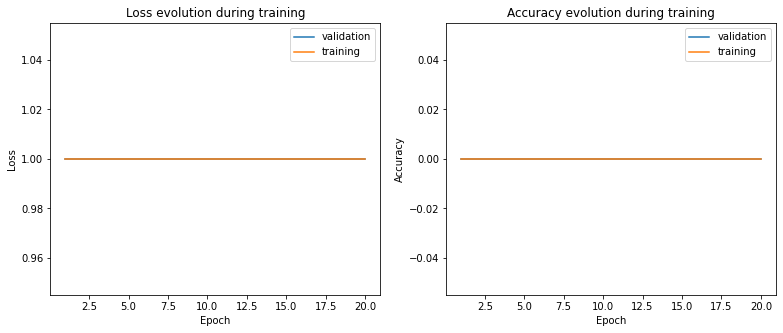

In [604]:
curves = train_model(
    CNN1,
    train_ds,
    val_ds,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,
)
show_curves(curves)

# ANTIGUO

In [5]:
test_marks = torch.tensor(np.load('data/Localización de husos sigma en el EEG del sueño/test_marks.npy'))
test_signals = torch.tensor(np.load('data/Localización de husos sigma en el EEG del sueño/test_signals.npy'))
train_marks = torch.tensor(np.load('data/Localización de husos sigma en el EEG del sueño/train_marks.npy'))
train_signals = torch.tensor(np.load('data/Localización de husos sigma en el EEG del sueño/train_signals.npy'))
val_marks = torch.tensor(np.load('data/Localización de husos sigma en el EEG del sueño/val_marks.npy'))
val_signals = torch.tensor(np.load('data/Localización de husos sigma en el EEG del sueño/val_signals.npy'))

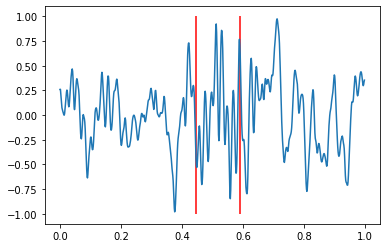

In [68]:
train_ds = torch.utils.data.TensorDataset(train_signals, train_marks)
val_ds = torch.utils.data.TensorDataset(val_signals, val_marks)
test_ds = torch.utils.data.TensorDataset(test_signals, test_marks)
a=np.load('data/Localización de husos sigma en el EEG del sueño/train_signals.npy')
b=np.load('data/Localización de husos sigma en el EEG del sueño/train_marks.npy')
t=np.arange(len(a[0]))*(1/800)
plt.plot(t,a[0]/40)
plt.vlines(b[0]*(1/800),-1,1,colors="r")

In [194]:
SMOOTH = 1e-6

def iou_pytorch(y_predicted: torch.Tensor, y_vals: torch.Tensor,eva=False):
    
    #print("predicho: ",y_predicted)
    #print("real: ",y_vals)
    #if eva==True:
    #    print("predicho_nuevo: ",y_predicted)
    #    print("real_nuevo: ",y_vals)
    largo=len(y_vals)
    error_array=np.zeros(largo)
    count=0
    for pred,y_val in zip(y_predicted,y_vals):
        pred=pred.squeeze(0)
        intervalo_inter = [max(pred[0],y_val[0]),min(pred[1],y_val[1])]
        rest = intervalo_inter[1] - intervalo_inter[0]
        inter = rest if rest>0 else 0

        len_predicted = pred[1] - pred[0]
        len_val = y_val[1] - y_val[0]
        union = len_predicted + len_val - inter
        error_array[count]=(inter/(union+1e-6))
        count+=1
        
    return torch.tensor(1-np.mean(error_array),requires_grad=True)

In [8]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()
    plt.show()

In [205]:
def evaluate(val_loader, model, criterion, use_gpu,delta=0.1):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0
    y_predicted=[]
    error_list=[]
    for x_val, y_val in val_loader:
        for x,y in zip(x_val,y_val):   
            x=x.unsqueeze(0)
            x=x.unsqueeze(0)
            if use_gpu:
                x = x.cuda()
                y = y.cuda()
            y_pred=model(x)
            y_pred=y_pred.reshape(2)
            #y_pred=y_pred.squeeze(0)
            #y_pred=y_pred.squeeze(0)
            #print(y_pred.shape)
            #print(y_pred)
            #print(y.shape)
            err=criterion(y_pred.unsqueeze(0),y.unsqueeze(0),eva=True)
            error_list.append(err)
            y_predicted.append(y_pred)
            cumulative_predictions += (err<delta)
            cumulative_loss += err

        data_count = x_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss

    return val_acc, val_loss

In [207]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted=[]
    for pred in x_batch:
        pred=pred.unsqueeze(0)
        pred=pred.unsqueeze(0)
        y_predicted.append(model(pred))
        
    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss

In [206]:
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
):

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()

        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            #train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            #class_prediction = torch.argmax(y_predicted, axis=1).long()
            #cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                #train_acc = cumulative_train_corrects / train_acc_count

                # print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")
                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}")
            iteration += 1


        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        #train_acc = cumulative_train_corrects / train_acc_count

       # curves["train_acc"].append(train_acc)
        #curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    # if data_augmentation:
    #     train_dataset.dataset.transform = original_transform

    return curves

In [12]:
class CNN_Model(nn.Module):
    eva=False
    def __init__(
        self,
        dropout_p,
        input_size=1,
        output_size=2,
    ):
        
        super().__init__()
        self.conv_blocks = nn.Sequential(
            
            nn.Conv1d(input_size, 1, kernel_size=1, stride=1, padding="same"),

            nn.Conv1d(input_size, 8, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(8, 16,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16,32,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32,64,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64,128,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(5),

            nn.Conv1d(256,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(5),

            nn.Conv1d(256,2,kernel_size=3, stride = 1, padding="same"),
            
        )

    def forward(self, x,evaa=False):
        if evaa==True:
            print("model: ", x.shape)
        return self.conv_blocks(x)

In [71]:
#lr = 5e-4
lr = 10
batch_size = 2
criterion = iou_pytorch
epochs = 20

CNN1 = CNN_Model(dropout_p=0.5)

In [72]:
curves = train_model(
    CNN1,
    train_ds,
    val_ds,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=False,
    data_augmentation=False,
)
#show_curves(curves)

Se han truncado las últimas 5000 líneas del flujo de salida.
predicho:  [tensor([[[-0.0494],
         [-0.0285]]], grad_fn=<ConvolutionBackward1>), tensor([[[-0.0327],
         [-0.0256]]], grad_fn=<ConvolutionBackward1>)]
predicho:  [tensor([[[-0.0369],
         [-0.0264]]], grad_fn=<ConvolutionBackward1>), tensor([[[-0.0378],
         [-0.0280]]], grad_fn=<ConvolutionBackward1>)]
predicho:  [tensor([[[-0.0393],
         [-0.0243]]], grad_fn=<ConvolutionBackward1>), tensor([[[-0.0342],
         [-0.0249]]], grad_fn=<ConvolutionBackward1>)]
predicho:  [tensor([[[-0.0463],
         [-0.0330]]], grad_fn=<ConvolutionBackward1>), tensor([[[-0.0571],
         [-0.0407]]], grad_fn=<ConvolutionBackward1>)]
predicho:  [tensor([[[-0.0335],
         [-0.0280]]], grad_fn=<ConvolutionBackward1>), tensor([[[-0.0344],
         [-0.0268]]], grad_fn=<ConvolutionBackward1>)]
predicho:  [tensor([[[-0.0381],
         [-0.0251]]], grad_fn=<ConvolutionBackward1>), tensor([[[-0.0397],
         [-0.0275]]], 

KeyboardInterrupt: ignored

## antiguo ANTIGUO

In [ ]:
class CNN_Model(nn.Module):
    def __init__(
        self,
        dropout_p,
        input_size=1,
        output_size=2
    ):
        super().__init__()
        self.conv_blocks = nn.Sequential(
            
            nn.Conv1d(input_size, 1, kernel_size=1, stride=1, padding=1),

            nn.Conv1d(input_size, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(8, 16,kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16,32,kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32,64,kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64,128,kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128,256,kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(5),

            nn.Conv1d(256,256,kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(5),

            nn.Conv1d(256,2,kernel_size=3, stride = 1, padding=1),
            
            #nn.Linear(1, 1),
        )


    def forward(self, x):
        x = x.unsqueeze(0)
        return self.conv_blocks(x).squeeze(1)

In [ ]:
model = CNN_Model(dropout_p = 0, input_size = 1, output_size = 2)
model(test_ds[0][0]).shape

torch.Size([2])

In [ ]:
model(test_ds[0][0])

tensor([-0.0036, -0.0085], grad_fn=<SqueezeBackward1>)

## Entrenamiento

In [ ]:
SMOOTH = 1e-6

def iou_pytorch(y_predicted: torch.Tensor, y_vals: torch.Tensor):
    # print("predicho: ",y_predicted)
    # print("real: ",y_vals)
    largo=len(y_vals)
    error_array=np.zeros(largo)

    for count,y_val in enumerate(y_vals):
        intervalo_inter = [max(y_predicted[0],y_val[0]),min(y_predicted[1],y_val[1])]
        rest = intervalo_inter[1] - intervalo_inter[0]
        inter = rest if rest>0 else 0

        len_predicted = y_predicted[1] - y_predicted[0]
        len_val = y_val[1] - y_val[0]
        union = len_predicted + len_val - inter
        error_array[count]=(inter/(union+1e-6))
        
    return torch.tensor(-np.mean(error_array),requires_grad=True)

In [ ]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()
    plt.show()

def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()
        
        y_predicted = model(x_val)
        
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss

In [ ]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    print("train_step: ", x_batch.shape)
    #x_batch=torch.reshape(x_batch,(1,800))
    print("train_step: ", x_batch.shape)
    print(x_batch)
    
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss

In [ ]:
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
):
    original_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    # if data_augmentation:
    #     train_dataset.dataset.transform = torchvision.transforms.Compose([
    #         original_transform,
    #         torchvision.transforms.RandomHorizontalFlip(),
    #         torchvision.transforms.Lambda(lambda x: x + torch.randn(3, 1, 1) * 0.05)
    #     ])

    # else:
    #     train_dataset.dataset.transform = original_transform
    # train_dataset.dataset.transform = original_transform

    # print(f"Using train transform: {train_dataset.dataset.transform}")
    # print(f"Using validation transform: {val_dataset.dataset.transform}")

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # for i,x in enumerate(train_loader):
    #     a=[0,1,2,3,4]
    #     if i in a:
    #         print("loader: ",x[1])

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0


        # Entrenamiento del modelo
        model.train()

        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            #train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            #class_prediction = torch.argmax(y_predicted, axis=1).long()
            #cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                #train_acc = cumulative_train_corrects / train_acc_count

                # print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")
                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}")
            iteration += 1
        print("Terminooooo")

        for i,x in enumerate(val_loader):
            a=[0,1,2]
            if i in a:
                print("loader: ",x[0][0])


    #     model.eval()
    #     with torch.no_grad():
    #         val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

    #     print(f"Val loss: {val_loss}, Val acc: {val_acc}")

    #     train_loss = cumulative_train_loss / train_loss_count
    #     #train_acc = cumulative_train_corrects / train_acc_count

    #    # curves["train_acc"].append(train_acc)
    #     #curves["val_acc"].append(val_acc)
    #     curves["train_loss"].append(train_loss)
    #     curves["val_loss"].append(val_loss)

    # print()
    # print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    # model.cpu()

    # if data_augmentation:
    #     train_dataset.dataset.transform = original_transform

    # return curves

In [ ]:
lr = 5e-4
batch_size = 64
criterion = iou_pytorch
epochs = 30

CNN1 = CNN_Model(dropout_p=0.5)
curves = train_model(
    CNN1,
    train_ds,
    val_ds,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=False,
    data_augmentation=False,
)

show_curves(curves)

Epoch 1/30
train_step:  torch.Size([64, 800])
train_step:  torch.Size([64, 800])
tensor([[-10.2268,  -6.0036,  -1.6235,  ...,   5.8184,   5.4444,   5.1112],
        [  2.1329,   2.2725,   2.5787,  ..., -11.7506, -14.1977, -15.1832],
        [ -1.7632,  -3.6840,  -6.3310,  ..., -21.3828, -23.5646, -25.6398],
        ...,
        [  9.6748,  10.0963,  10.9443,  ...,   4.1570,   4.6682,   4.2069],
        [  8.3287,   9.1388,   9.1046,  ...,   7.8205,   8.5937,   9.5831],
        [ -8.3147, -10.5037, -11.6409,  ...,   2.6186,   1.1632,  -0.4692]])


RuntimeError: ignored